In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from PIL import Image

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers  import Input, Dense, Dropout, Flatten, Conv2D,MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.python.keras import utils
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.python.keras.layers import concatenate
from tensorflow.python.keras.models import Model
#from tensorflow.python.layers.merge import concatenate

np.random.seed(42)

%matplotlib inline

In [2]:
# Look at list of first 5 images from Normal class
!ls ../input/chest_xray_3classes/chest_xray/train/NORMAL/* | head

../input/chest_xray_3classes/chest_xray/train/NORMAL/IM-0115-0001.jpeg
../input/chest_xray_3classes/chest_xray/train/NORMAL/IM-0117-0001.jpeg
../input/chest_xray_3classes/chest_xray/train/NORMAL/IM-0119-0001.jpeg
../input/chest_xray_3classes/chest_xray/train/NORMAL/IM-0122-0001.jpeg
../input/chest_xray_3classes/chest_xray/train/NORMAL/IM-0125-0001.jpeg
../input/chest_xray_3classes/chest_xray/train/NORMAL/IM-0127-0001.jpeg
../input/chest_xray_3classes/chest_xray/train/NORMAL/IM-0128-0001.jpeg
../input/chest_xray_3classes/chest_xray/train/NORMAL/IM-0129-0001.jpeg
../input/chest_xray_3classes/chest_xray/train/NORMAL/IM-0131-0001.jpeg
../input/chest_xray_3classes/chest_xray/train/NORMAL/IM-0133-0001.jpeg


Normal
Size of image:(1468, 993)


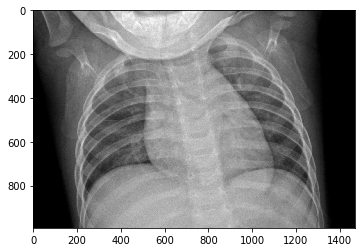

In [3]:
# Look at an example of a Normal chest X_ray
image_ex = load_img("../input/chest_xray_3classes/chest_xray/train/NORMAL/IM-0133-0001.jpeg")

print("Normal")
print(f"Size of image:{image_ex.size}")
plt.imshow(image_ex)
plt.show()

In [4]:
ls ../input/chest_xray_3classes/chest_xray/train/VIRUS/* | head

../input/chest_xray_3classes/chest_xray/train/VIRUS/person1000_virus_1681.jpeg
../input/chest_xray_3classes/chest_xray/train/VIRUS/person1003_virus_1685.jpeg
../input/chest_xray_3classes/chest_xray/train/VIRUS/person1004_virus_1686.jpeg
../input/chest_xray_3classes/chest_xray/train/VIRUS/person1005_virus_1688.jpeg
../input/chest_xray_3classes/chest_xray/train/VIRUS/person1007_virus_1690.jpeg
../input/chest_xray_3classes/chest_xray/train/VIRUS/person1008_virus_1691.jpeg
../input/chest_xray_3classes/chest_xray/train/VIRUS/person1009_virus_1694.jpeg
../input/chest_xray_3classes/chest_xray/train/VIRUS/person100_virus_184.jpeg
../input/chest_xray_3classes/chest_xray/train/VIRUS/person1010_virus_1695.jpeg
../input/chest_xray_3classes/chest_xray/train/VIRUS/person1015_virus_1701.jpeg


Virus
Size of image:(1104, 792)


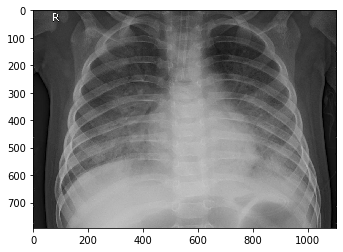

In [7]:
image_ex = load_img("../input/chest_xray_3classes/chest_xray/train/VIRUS/person100_virus_184.jpeg")

print("Virus")
print(f"Size of image:{image_ex.size}")
plt.imshow(image_ex)
plt.show()

In [8]:
ls ../input/chest_xray_3classes/chest_xray/test/BACTERIA/* | tail

../input/chest_xray_3classes/chest_xray/test/BACTERIA/person94_bacteria_456.jpeg
../input/chest_xray_3classes/chest_xray/test/BACTERIA/person94_bacteria_457.jpeg
../input/chest_xray_3classes/chest_xray/test/BACTERIA/person94_bacteria_458.jpeg
../input/chest_xray_3classes/chest_xray/test/BACTERIA/person95_bacteria_463.jpeg
../input/chest_xray_3classes/chest_xray/test/BACTERIA/person96_bacteria_464.jpeg
../input/chest_xray_3classes/chest_xray/test/BACTERIA/person96_bacteria_465.jpeg
../input/chest_xray_3classes/chest_xray/test/BACTERIA/person96_bacteria_466.jpeg
../input/chest_xray_3classes/chest_xray/test/BACTERIA/person97_bacteria_468.jpeg
../input/chest_xray_3classes/chest_xray/test/BACTERIA/person99_bacteria_473.jpeg
../input/chest_xray_3classes/chest_xray/test/BACTERIA/person99_bacteria_474.jpeg


Bacteria
Size of image:(1000, 704)


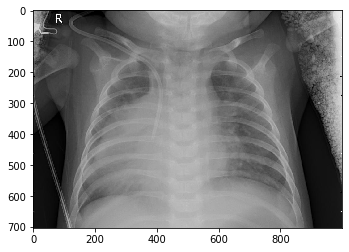

In [17]:
image_ex = load_img("../input/chest_xray_3classes/chest_xray/test/BACTERIA/person95_bacteria_463.jpeg")

print("Bacteria")
print(f"Size of image:{image_ex.size}")
plt.imshow(image_ex)
plt.show()

Looking at the three images, I can see that most of the images are straight on images of the chest and the majority are straight. However, there are a few which are a little off center, so I will need a way to accomadate for this shift. Another observation is that the size of the images is not standard. The images are of different sizes  and some are zoomed in; I will need to combat this. 

In [15]:
# Directory paths
train_dir = "../input/chest_xray_3classes/chest_xray/train"
val_dir = "../input/chest_xray_3classes/chest_xray/val"
test_dir = "../input/chest_xray_3classes/chest_xray/test"

models = list()

In [20]:
# resnet50
import tensorflow
from tensorflow.keras.applications.resnet50 import ResNet50

model_res = Sequential()

model_res.add(ResNet50(include_top = False,
                   weights = "imagenet",
                   input_shape=(150,150,3)))

# Dropout
model_res.add(Dropout(0.5))

# Pooling layer
model_res.add(GlobalAveragePooling2D())

# Dense layer
model_res.add(Dense(128, 
                activation = "relu"))

# Batch Normalizer
model_res.add(BatchNormalization())

# Output layer
model_res.add(Dense(3,
                activation = "softmax"))

#Load weights 
model_res.load_weights("../output/3classes_resnet50_model.h5")

for layer in model_res.layers:
    # make not trainable
    layer.trainable = False

In [21]:
# InceptionV3
from tensorflow.keras.applications.inception_v3 import InceptionV3

model_in = Sequential()

model_in.add(InceptionV3(include_top = False,
                      weights = 'imagenet',
                      input_shape=(150,150,3)))

# Dropout
model_in.add(Dropout(0.5))

# Pooling layer
model_in.add(GlobalAveragePooling2D())

# Dense layer
model_in.add(Dense(128, 
                activation = "relu"))

# Batch Normalizer
model_in.add(BatchNormalization())

# Output layer
model_in.add(Dense(3,
                activation = "softmax"))

#Load weights 
model_in.load_weights("../output/3classes_inception_model.h5")

for layer in model_in.layers:
    # make not trainable
    layer.trainable = False

In [28]:
# a single input layer
inputs = Input(shape=(150,150,3))

# model 1
x1 = model_res(inputs)

# model 2 
x2 = model_in(inputs)

# merging models
x3 = concatenate([x1, x2])

# output layer
predictions = Dense(3, activation='softmax')(x3)

# generate a model from the layers above
model = Model(inputs=inputs, outputs=predictions)

In [29]:
# check size
model.input, model.output

(<tf.Tensor 'input_7:0' shape=(None, 150, 150, 3) dtype=float32>,
 <tf.Tensor 'dense_12/Identity:0' shape=(None, 3) dtype=float32>)

In [30]:
# Early Stopping
early_stop = EarlyStopping(monitor = "val_loss",
                           min_delta = 0,
                           patience = 3)
# Multiplies the learning rate by factor of 0.1 when the monitored metric (val_acc) plateaus 
# this will prevent overshooting -- since plateau means getting close to local minimum (lowest val loss)
#lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

# Compile model
model.compile(loss = "categorical_crossentropy",
              optimizer = Adam(lr = 0.0001),
              metrics = ["accuracy"])

In [31]:
# Input shape
model.input_shape[1:3]

(150, 150)

In [90]:
# Data Generator 

#Defining image augmentation
train_idg = ImageDataGenerator(rescale = 1./255,
                               zoom_range = 0.2,
                               shear_range = 0.2,
                               rotation_range = 20,
                               horizontal_flip = True)

test_idg = ImageDataGenerator(rescale = 1./255)

#Creating data loaders
train_gen = train_idg.flow_from_directory(train_dir,
                                    model.input_shape[1:3],
                                    color_mode = "rgb",
                                    seed = 42,
                                    batch_size = 16, #8,16,32
                                    shuffle = True)

val_gen =  test_idg.flow_from_directory(val_dir,
                                    model.input_shape[1:3],
                                    color_mode = "rgb",
                                    seed = 42,
                                    batch_size = 16, 
                                    shuffle = True)

test_gen = test_idg.flow_from_directory(test_dir,
                                    model.input_shape[1:3],
                                    color_mode = "rgb",
                                    seed = 42,
                                    batch_size = 8,
                                    shuffle = False)

Found 5216 images belonging to 3 classes.
Found 16 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


In [33]:
# Fit model
hist = model.fit_generator(train_gen, 
                    validation_data = val_gen,
                    callbacks = [early_stop],
                    epochs = 20)

Epoch 1/20
326/326 [==============================] - 1419s 4s/step - loss: 0.9889 - accuracy: 0.4948 - val_loss: 1.0678 - val_accuracy: 0.1875
Epoch 2/20
326/326 [==============================] - 1371s 4s/step - loss: 0.9416 - accuracy: 0.5077 - val_loss: 1.0411 - val_accuracy: 0.2500
Epoch 3/20
326/326 [==============================] - 1377s 4s/step - loss: 0.9010 - accuracy: 0.6102 - val_loss: 1.0165 - val_accuracy: 0.4375
Epoch 4/20
326/326 [==============================] - 1386s 4s/step - loss: 0.8631 - accuracy: 0.7556 - val_loss: 0.9938 - val_accuracy: 0.4375
Epoch 5/20
326/326 [==============================] - 1387s 4s/step - loss: 0.8287 - accuracy: 0.7742 - val_loss: 0.9727 - val_accuracy: 0.5000
Epoch 6/20
326/326 [==============================] - 1396s 4s/step - loss: 0.7955 - accuracy: 0.7914 - val_loss: 0.9529 - val_accuracy: 0.5000
Epoch 7/20
326/326 [==============================] - 1417s 4s/step - loss: 0.7648 - accuracy: 0.7998 - val_loss: 0.9348 - val_accuracy:

In [34]:
# Evaluate model on test data.
scores = model.evaluate_generator(test_gen)
labels = model.metrics_names

# Show model performance
print(f'{labels[0]}: {scores[0]}')
print(f'{labels[1]}: {scores[1]* 100}%')

# Summary of the layers of the model
#model.summary()

loss: 0.5390948563432082
accuracy: 84.45512652397156%


In [108]:
# Predicted classes - Predicted Positives and Predicted Negatives 
predictions = model.predict_generator(test_gen)
predicted_classes = np.argmax(predictions,axis=1)

In [91]:
# True classes - True Positives and True Negatives 
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())   

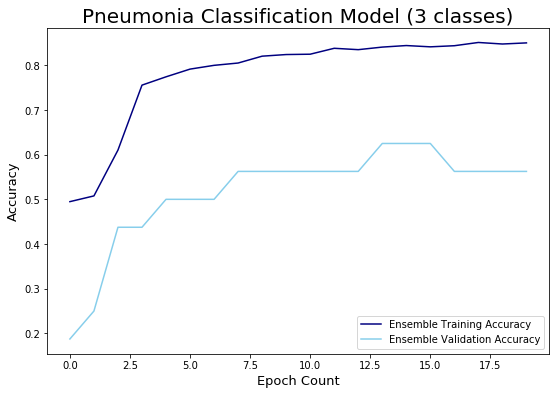

In [78]:
# Plot
train_loss = hist.history["accuracy"]
test_loss = hist.history["val_accuracy"]
plt.figure(figsize = (9,6))


plt.plot(train_loss, label = "Ensemble Training Accuracy", color = "navy")
plt.plot(test_loss, label = "Ensemble Validation Accuracy" , color= "skyblue")
plt.title("Pneumonia Classification Model (3 classes)", fontsize = 20)
plt.xlabel("Epoch Count", fontsize = 13)
plt.ylabel("Accuracy", fontsize = 13)
plt.legend();

In [43]:
# save weights from this model model
model.save_weights("../output/3classes_ensemble_model.h5")